In [38]:
# import packacges 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter
import ase
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
import os
from scipy.ndimage import gaussian_filter1d

# Import Data 

In [39]:
# Load the CSV file
file_path = 'data/aGC-DFT_data.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Convert each column into a nump array, removing NaN values
for col in df.columns:
    globals()[col] = df[col].dropna().to_numpy()  # Remove NaNs and convert to NumPy array

# Print the full DataFrame for verification
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.to_string())


    index          metal     a   c/a   fermi  dband_center  dband_width  d_band_filling  vac_E   bare_mu  bare_alpha      bare_E    no3_mu  no3_alpha     no3_q       no3_E    no3_G  tstate_mu  tstate_alpha  tstate_q    tstate_E  tstate_G  fstate_mu  fstate_alpha    fstate_E
0       0  saa_rh1cu_111  3.70  1.00 -0.3176     -1.558296     1.754135        0.886942  4.278  0.012532    2.820419 -113.064233  0.471479   3.102981 -0.288143 -137.517475 -137.274   0.316809      3.020287 -0.329207 -136.548700 -136.3430   0.415778      2.998704 -138.151342
1       1  saa_ni1cu_111  3.70  1.00 -0.3775     -1.434713     1.559326        0.914765  4.198 -0.000439    2.804782 -111.298119  0.433115   3.071742 -0.312157 -135.878123 -135.635   0.157469      3.011083 -0.289971 -135.372400 -135.1630   0.403901      2.972572 -136.492408
2       2  saa_ru1cu_111  3.70  1.00 -0.3234     -1.376881     1.915440        0.840104  4.307  0.020128    2.819262 -113.885310  0.445798   3.119464 -0.267557 -138.481749 -13

In [40]:
# Read the CSV file
file_path = 'data/jdftx_data.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Convert each column into a NumPy array, removing NaN values
for col in df.columns:
    globals()[col] = df[col].dropna().to_numpy()  # Remove NaNs and convert to NumPy array

# Print the full DataFrame for verification
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.to_string())

    index  jpotential    jfermi  jbare_surf_charge      jbare_E  jno3_surf_charge       jno3_E       jno3_G  jtstate_surf_charge    jtstate_E    jtstate_G
0       0        -1.0 -0.134502         684.686707 -7267.561281        707.963249 -7325.760100 -7325.752309                  NaN          NaN          NaN
1       1        -0.8 -0.141852         684.440099 -7267.527223        707.780806 -7325.734891 -7325.725814                  NaN          NaN          NaN
2       2        -0.6 -0.149202         684.225441 -7267.495995        707.581343 -7325.705879 -7325.697648           707.350422 -7325.647379 -7325.641425
3       3        -0.4 -0.156552         684.031579 -7267.466392        707.408797 -7325.679517 -7325.669631           707.176091 -7325.620731 -7325.614704
4       4        -0.2 -0.163902         683.851003 -7267.437455        707.234327 -7325.651565 -7325.641826                  NaN          NaN          NaN
5       5         0.0 -0.171252         683.664482 -7267.406189       

# aGC-DFT Model

In [41]:
# missing indicies for dissociation barriers 
missing_data = [8, 12, 16]  

# reference states for calculation computed from VASP
hno3 = -27.63929776
hno3_G = -27.658
h2 = -6.99048756
h2_G = -7.259

# metal organization 
saa_111 = 4
pure_111 = 9
saa_100 = 13
pure_100 = 17

# model parameters
area = 23.71355 # surface area as calculated from ASE

# compute pzc from work function for each metal 
bare_pzc = vac_E - fermi - 4.66 # reference state of 4.66 to align with JDFTx 

# analytical grand canonical method 
def aGC_DFT(mu, alpha, E_dft, potential, d, e_r, slab_alpha=bare_alpha, U_pzc = bare_pzc): 
    epsilon = e_r * 0.0055 # convert relative permittivity to absolute permittivity

    if len(U_pzc) != len(E_dft):  # Remove the elements at the specified indices
        U_pzc = np.delete(U_pzc, missing_data)       
        slab_alpha = np.delete(slab_alpha, missing_data)
       
    U_lambda = U_pzc + mu / area / epsilon # compute shift in PZC 

    energy = [E_dft - (1/2 * epsilon * area / d) * (U - U_lambda)**2 + mu * (U - U_lambda) / d  + (alpha - slab_alpha) / 2 * ((U - U_lambda) / d)**2 for U in potential] # compute grand free energy 
    return np.vstack(energy).T

# compute grand freen energies assuming they are equivalent to their PZC values 
def null(mu, alpha, E_dft, potential, U_pzc = bare_pzc): 
    if len(U_pzc) != len(E_dft): 
        U_pzc = np.delete(U_pzc, missing_data) # Remove the elements at the specified indices
        #print('Deleted missing indices')
    energy = [E_dft - 0*U for U in potential] # compute E(U) = E_PZC at each potential 
    return np.vstack(energy).T

## NO3* on Cu(111): CHE vs aGC-DFT vs eGC-DFT

CHE electrosorption valency: -1.0 eV/V
aGC-DFT electrosorption valency: -0.6935185884854034 eV/V and R2 value: 0.9998710502212003
JDFTx electrosorption valency: -0.5818725483751717 eV/V and R2 value: 0.9987624744214504


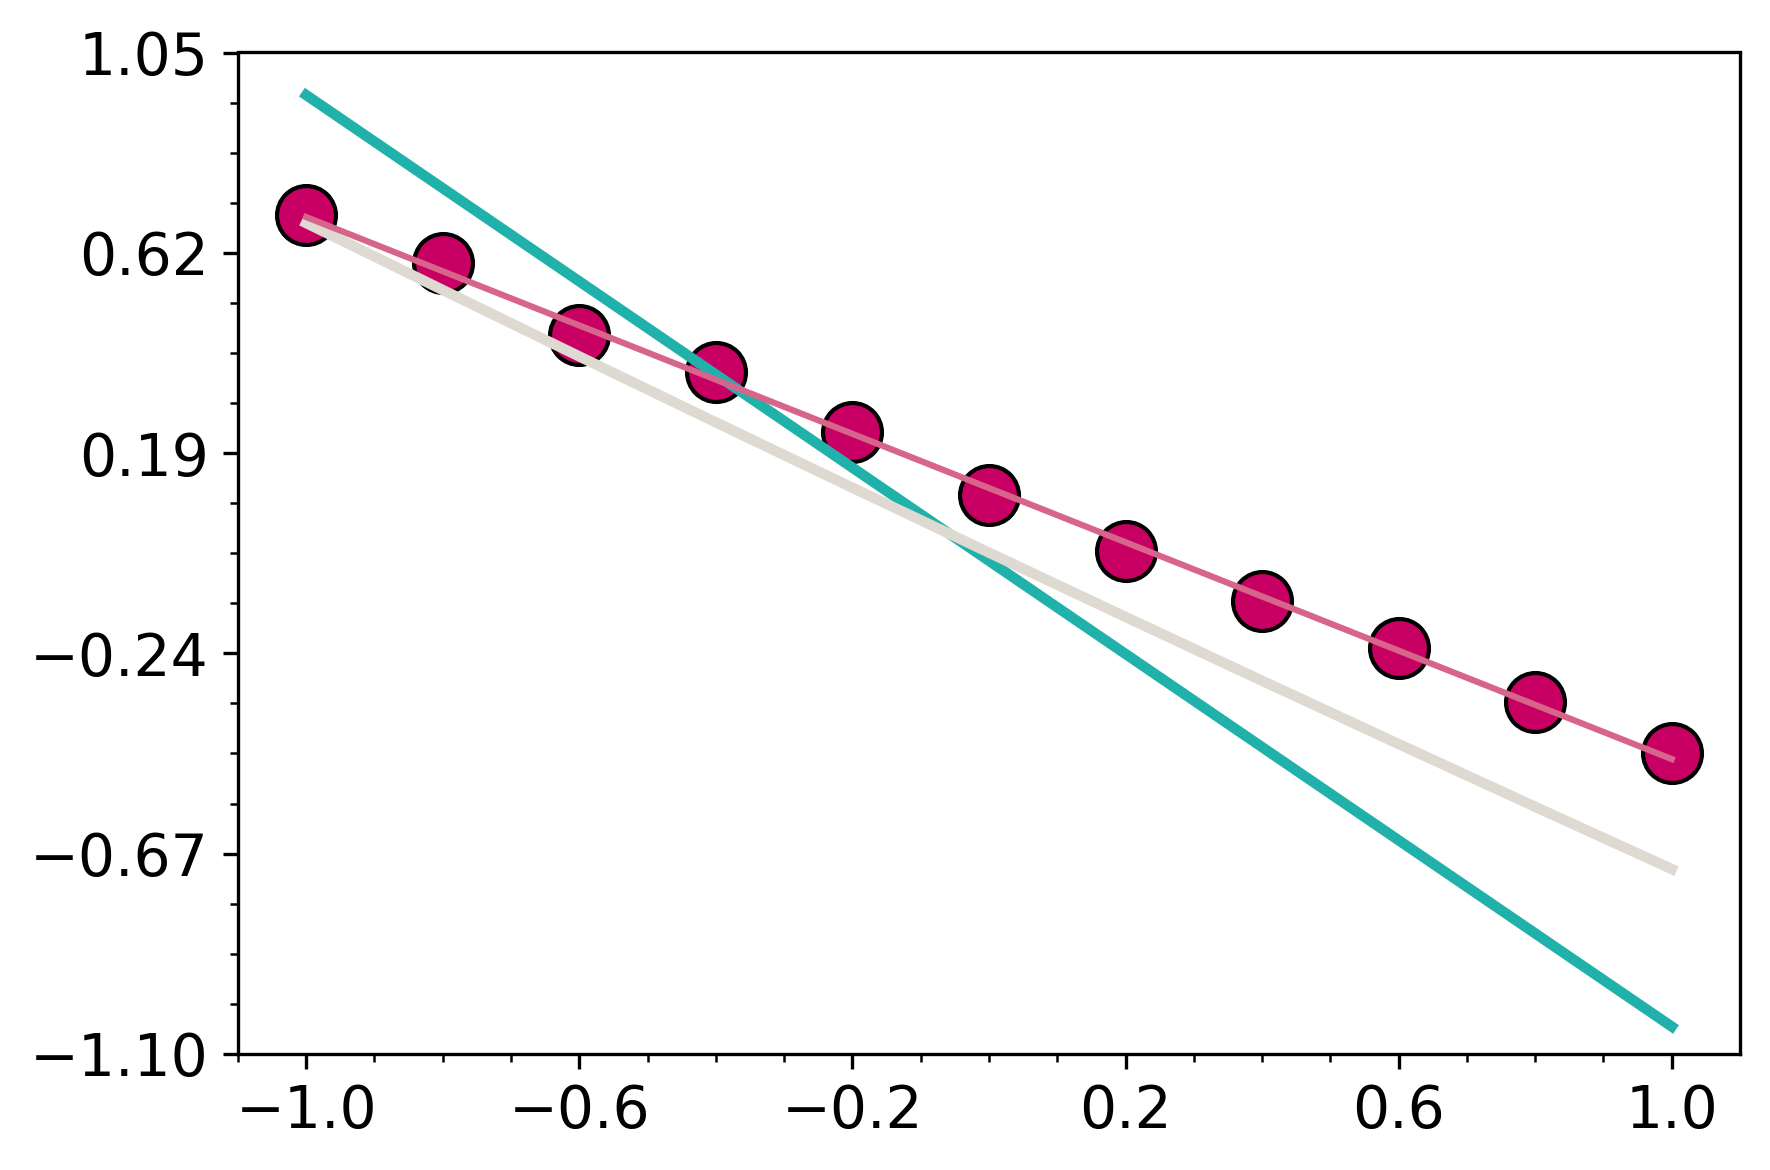

In [42]:
# potential range 
potential = np.arange(-1.0, 1.2, 0.2) # V vs SHE
U = potential

# compute grand free energies from analytical method 
gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, 3, 78.4) # double layer thickness of 3 A and dielectric constant of 78.4
gc_energy_no3= aGC_DFT(no3_mu, no3_alpha, no3_G, potential, 3, 78.4) 

# compute no3 adsorption energy with both aGC-DFT 
no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3_G - 1/2 * h2_G) - U + 0.480 - 0.0592*7 # correct for PCET, pH
no3_ads_cu = no3_adsorption[4] # specify Cu(111)

# compute no3 adsorption enegry with CHE 
no3_adsorption_che = null(no3_mu, no3_alpha, no3_G, potential) - (null(bare_mu, bare_alpha, bare_E, potential) + hno3_G - 1/2 * h2_G) - U + 0.480 - 0.0592*7
no3_ads_che_cu = no3_adsorption_che[4] #specify Cu(111)

###### JDFTx

# reference states for calculation computed from JDFTx
jhno3 = -58.735483320473485
jhno3_G = jhno3 + -0.013
jh2 = -1.177143541694519
jh2_G = jh2 + -0.039

# comptue no3 adsorption energy with jdftx for Cu(111)
jdftx_slab_n0 = 684 # electron count for pure Cu(111) slab
jdftx_slab_phi = (jbare_E - (jbare_surf_charge - jdftx_slab_n0) * jfermi)  # grand free energy of the slab 
jdftx_ads_n0 = 707 # electron count for NO3* on Cu(111)
jdftx_ads_phi = (jno3_G - (jno3_surf_charge - jdftx_ads_n0) * jfermi) # grand free energy of NO3* on Cu(111)
jdftx_no3_adsorption = ((jdftx_ads_phi - (jdftx_slab_phi + jhno3_G - 1/2 * jh2_G)) * 27.2114 - jpotential) + 0.480 - 0.0592*7

# Calculate the lines of best fit for (1) jdftx and aGC-DFT (assuming linear potential depedence)
jdftx_eval, jdftx_intercept, jdftx_r_value, _, _ = linregress(jpotential, jdftx_no3_adsorption) # compute electrosorption valencies 
aGC_eval, aGC_intercept, aGCr_value, _, _ = linregress(potential, no3_ads_cu) # compute electrosorption valencies 

print(f'CHE electrosorption valency: {-1.0} eV/V')
print(f'aGC-DFT electrosorption valency: {aGC_eval} eV/V and R2 value: {aGCr_value**2}')
print(f'JDFTx electrosorption valency: {jdftx_eval} eV/V and R2 value: {jdftx_r_value**2}')

# Create the scatter plot
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(potential, no3_ads_che_cu, color="lightseagreen", linewidth=2.5) #aGC-DFT
plt.plot(potential, no3_ads_cu, color="#dedad2", linewidth=2.5) # CHE
plt.scatter(jpotential, jdftx_no3_adsorption, color="#c80064", s=200, edgecolor='black') # JDFTx
plt.plot(potential, jdftx_eval * potential + jdftx_intercept, color="#d7658b", linestyle='-') #JDFTx line of best fit

# plot formatting
plt.xticks(np.arange(-1.0, 1.4, 0.4), fontsize=14)
plt.yticks(np.linspace(-1.1, 1.05, 6), fontsize=14)
plt.ylim(-1.1, 1.05)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Save as .svg 
plt.tight_layout()
plt.savefig('figures/dEads-NO3.svg', format='svg', dpi=300, bbox_inches='tight')

## Electrosorption valencies vs dipole moment for NO3 adsorption

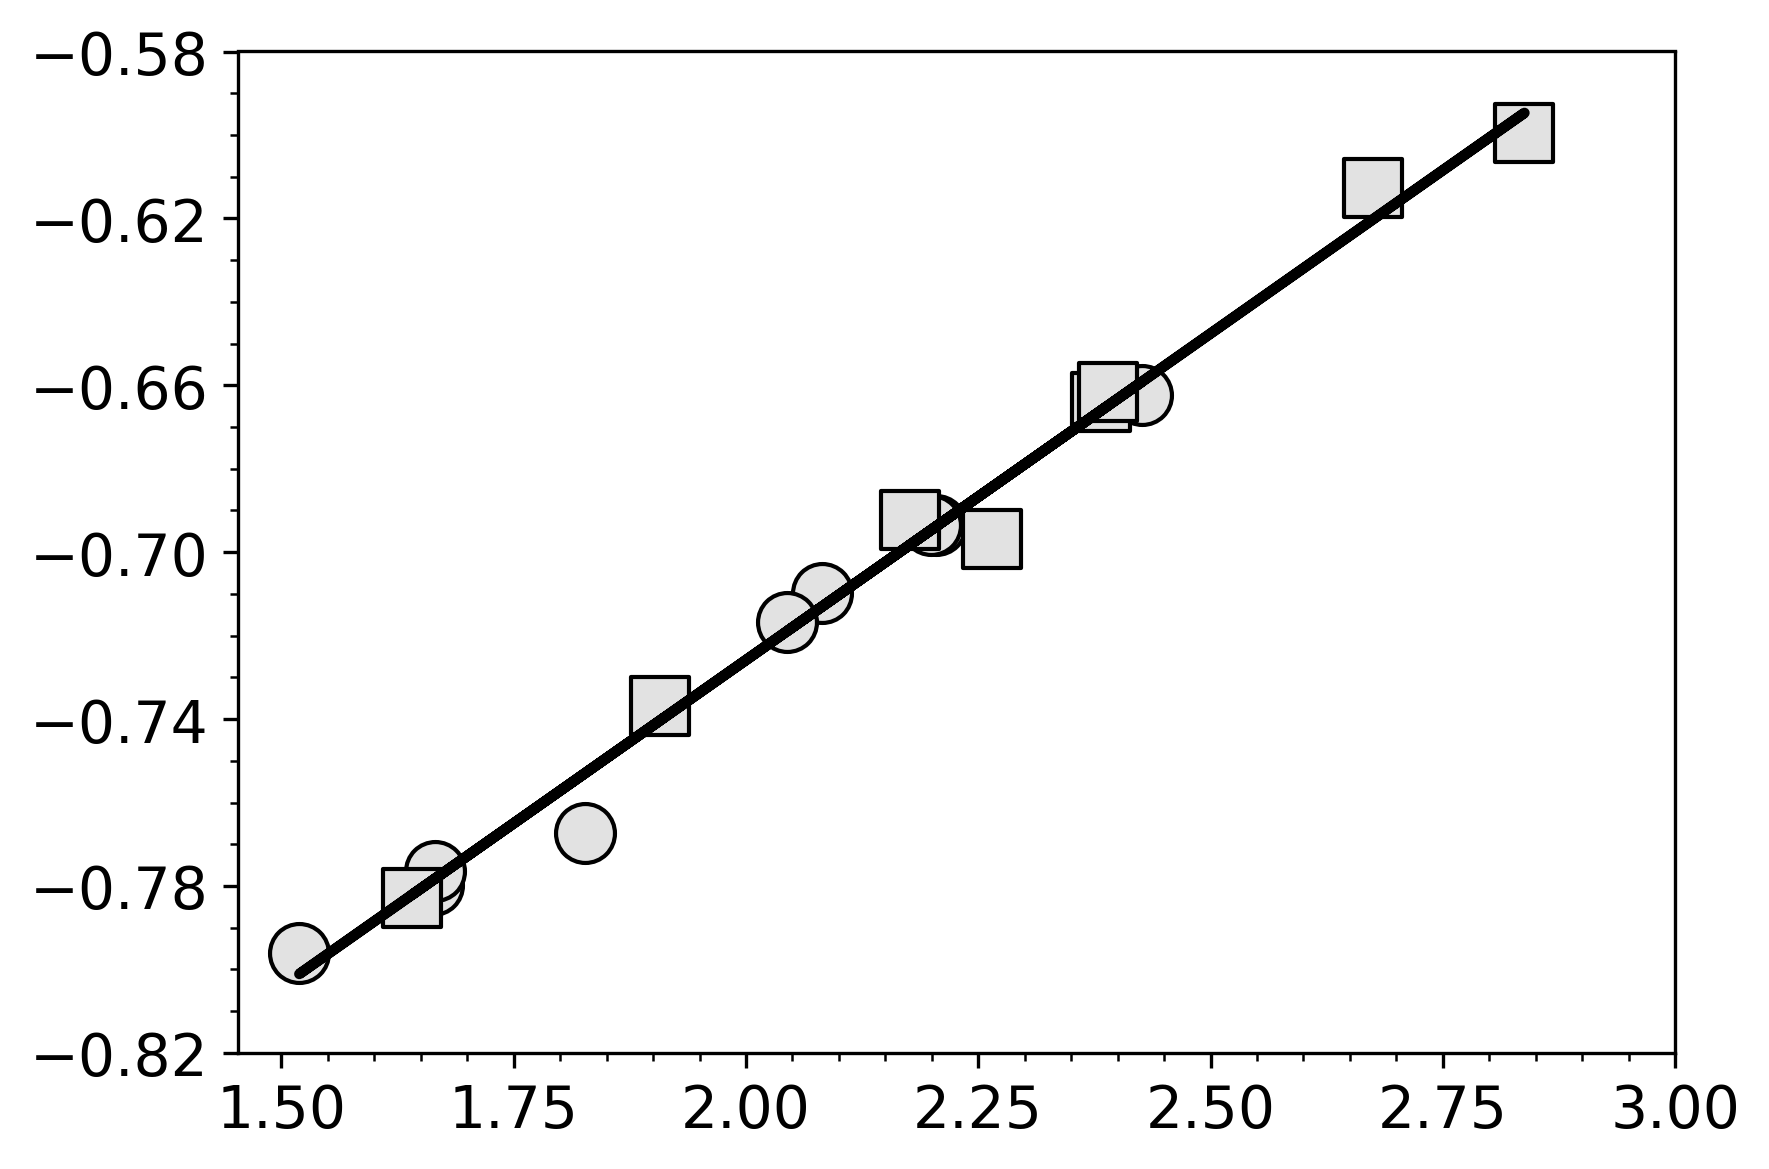

In [43]:
gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, 3, 78.4) # compute grand free energy of bare slab 
gc_energy_no3= aGC_DFT(no3_mu, no3_alpha, no3_E, potential, 3, 78.4) # compute grand free energy of covered slab 

# computing adsorption energies 
no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3 - 1/2 * h2) - U # compute adsorption energy usign aGC-DFT
electrosorption_v = []
r2_value = []

# calculate electrosorption valencies for each catalyst 
for metal in no3_adsorption: 
    slope, intercept, r_value, p_value, std_err = linregress(U, metal) # compute electrosorption valencies 
    electrosorption_v.append(slope)
    r2_value.append(r_value**2)
electrosorption_v = np.array(electrosorption_v) # store electrosorption valencies 

#regress electrsorption valencies vs the shift in dipole moment
no3_dipole_shift = (no3_mu - bare_mu) * 4.803 # compute shift in dipole moment and covert ot Debye 
m, b, r_value, p_value, std_err = linregress(no3_dipole_shift, electrosorption_v) # fit electrosoprtion valency vs shift in dipole moment

## plot results ##
plt.figure(figsize=(6, 4), dpi=300)
plt.scatter(no3_dipole_shift[:saa_111] , electrosorption_v[:saa_111], color="#e2e2e2", s=200, edgecolors='black')
plt.scatter(no3_dipole_shift[saa_111:pure_111], electrosorption_v[saa_111:pure_111], color="#e2e2e2", s=200, edgecolors='black')
plt.scatter(no3_dipole_shift[pure_111:saa_100], electrosorption_v[pure_111:saa_100], color="#e2e2e2", s=200, marker='s', edgecolors='black')
plt.scatter(no3_dipole_shift[saa_100:], electrosorption_v[saa_100:], color="#e2e2e2", s=200, marker='s', edgecolors='black')
plt.plot(no3_dipole_shift, m * no3_dipole_shift + b, color='black', linewidth=2.5)

# plot formatting 
plt.yticks(np.linspace(-0.82, -0.58, 7), fontsize=14)
plt.xticks(np.linspace(1.5, 3, 7), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  
plt.tick_params(axis='x', which='minor', length=2)

# save as .svg
plt.tight_layout()
plt.savefig('figures/dipole_moment_v_no3_electrosorption.svg')
    


# Dipole moment vs charge transfer for NO3 adsorption 

The R2 value of the fit is: 0.8035909218278297


/var/folders/sl/r8hdl4bx3j9303t8kxh1v50w0000gn/T/ipykernel_17394/3862950590.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=custom_cmap))


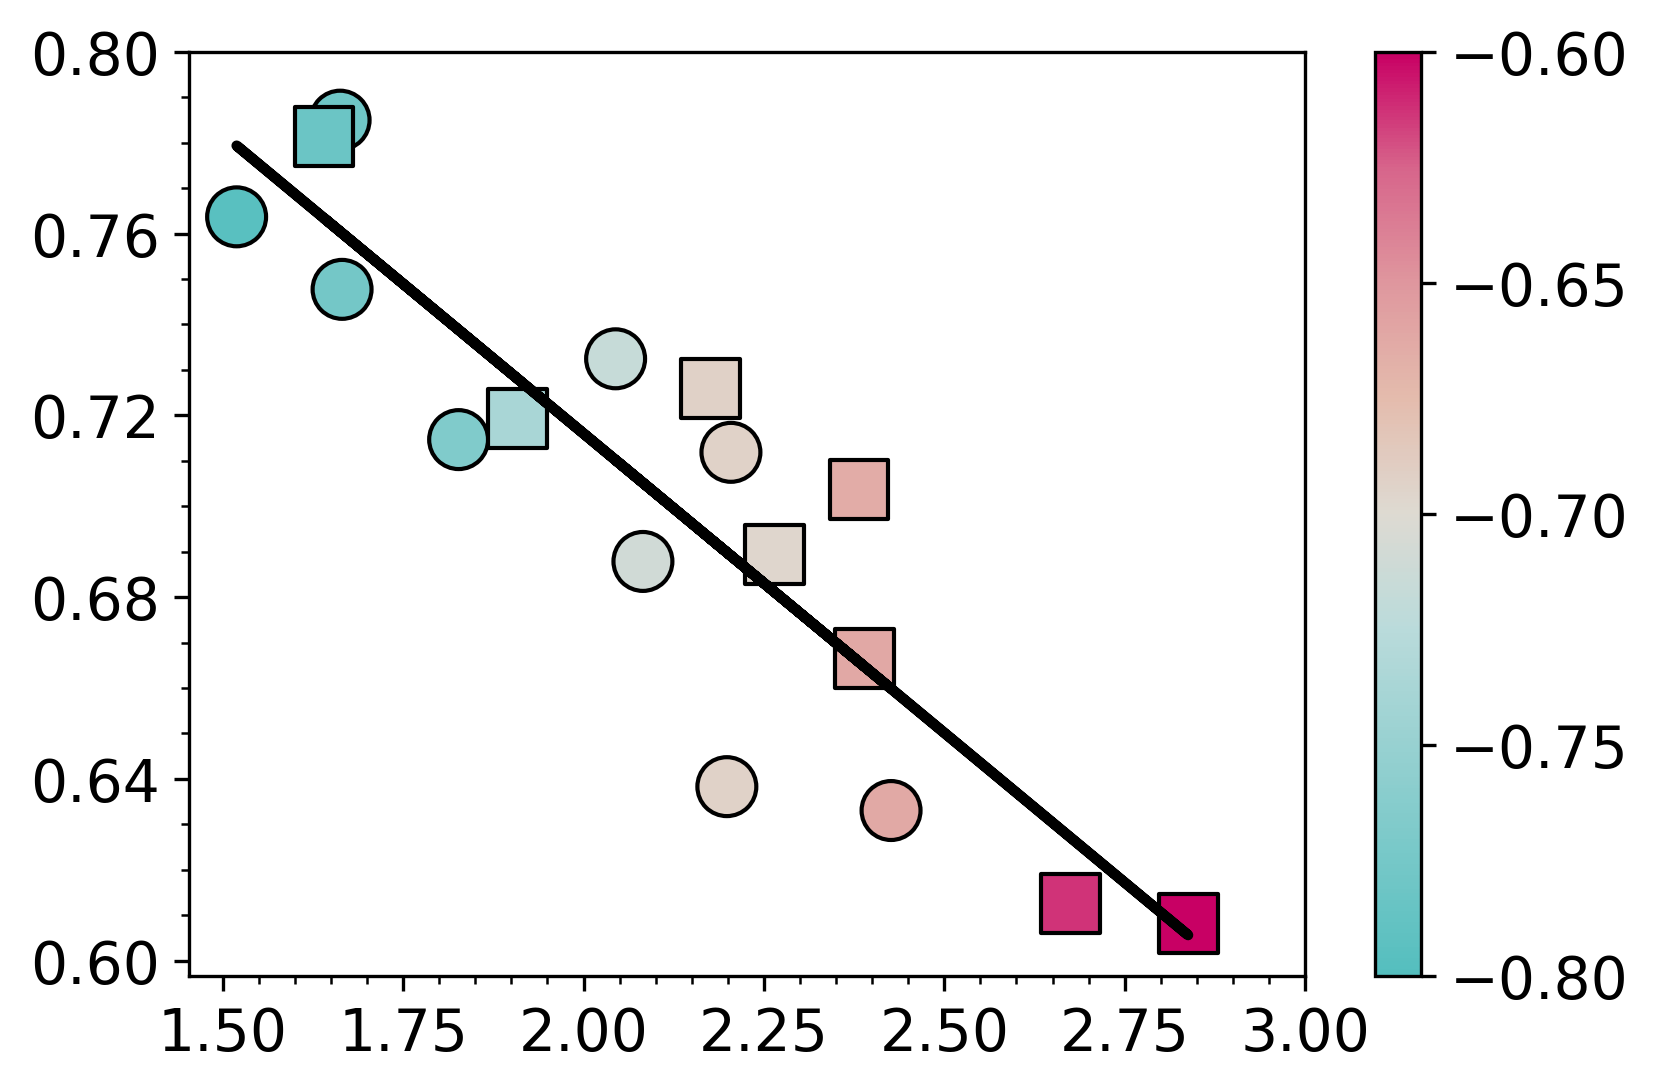

In [44]:
# output charge transfer for NO3 adsorption
no3_delta_q = no3_q + 1 # -1 reference state for NO3-
m, b, r_value, p_value, std_err = linregress(no3_dipole_shift, no3_delta_q) # fit electrosoprtion valency vs shift in dipole moment
print(f'The R2 value of the fit is: {r_value**2}')


### Plot results ###
# Define custom colormap using the provided color codes
custom_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

plt.figure(figsize=(6, 4), dpi=300)
norm = Normalize(vmin=-0.80, vmax=-0.60)

sc = plt.scatter(
    no3_dipole_shift[:pure_111], no3_delta_q[:pure_111],
    c=electrosorption_v[:pure_111],  # Color based on electrosorption values
    cmap=custom_cmap,    # Use the custom colormap
    norm=norm,           # Apply normalization
    s=200,               # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

sc = plt.scatter(
    no3_dipole_shift[pure_111:pure_100], no3_delta_q[pure_111:pure_100],
    c=electrosorption_v[pure_111:pure_100],  # Color based on electrosorption values
    cmap=custom_cmap,    # Use the custom colormap
    norm=norm,           # Apply normalization
    marker='s',          # Square marker
    s=200,               # Marker size
    edgecolors='black',
    alpha=1          # Transparency
)

# add line of best fit
plt.plot(no3_dipole_shift, m * no3_dipole_shift + b, color='black', linewidth=2.5)

# add a colorbar
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=custom_cmap))
cbar.ax.tick_params(labelsize=14)  # Set font size of tick marks

# Plot formatting
plt.yticks(np.arange(0.60, 0.80, 0.04), fontsize=14)
plt.xticks(np.arange(0.30*5, 0.65*5, 0.05*5), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Save as .svg
plt.savefig('figures/dipole_moment_v_charge_transfer.svg', format='svg', dpi=300)


## pDOS of metals vs charge transfer 

In [45]:
# function to read DOS file generate from VASP and post processing with vtst scripts
def extract_dos(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract column headers from the first line
    headers = lines[0].strip().split()
    
    # Initialize dictionary to store columns
    data = {header: [] for header in headers}
    
    # Read the data lines
    for line in lines[1:]:
        values = line.strip().split()
        for header, value in zip(headers, values):
            data[header].append(float(value))
    
    # Initialize dictionary for summed data
    sum_keys = {'s': [], 'p': [], 'd': [], 'f': []}
    
    # Determine which columns to sum
    for key in sum_keys.keys():
        cols_to_sum = [col for col in headers if col.startswith(key)]
        
        # Sum the columns element-wise if they exist
        if cols_to_sum:
            sum_keys[key] = [sum(values) for values in zip(*(data[col] for col in cols_to_sum))]
            data[f'{key}_total'] = sum_keys[key]
    
    return data

def calculate_d_band_properties(energies, d_sum, spin_polarized=1):

    # Calculate the d-band center (energy-weighted average)
    numerator_center = np.trapz(energies * d_sum, x=energies)  # Integral of energy * DOS
    denominator = np.trapz(d_sum, x=energies)  # Integral of DOS
    d_band_center = numerator_center / denominator if denominator != 0 else None

    # Calculate the d-band width (second central moment, n=2)
    numerator_width = np.trapz(((energies - d_band_center) ** 2) * d_sum, x=energies)
    d_band_width = np.sqrt(numerator_width / denominator) if denominator != 0 else None

    return d_band_center, d_band_width

## Pure metals 

['acu_100.txt', 'acu_111.txt', 'bpd_100.txt', 'bpd_111.txt', 'cni_100.txt', 'cni_111.txt', 'dru_0001.txt', 'erh_100.txt', 'erh_111.txt']


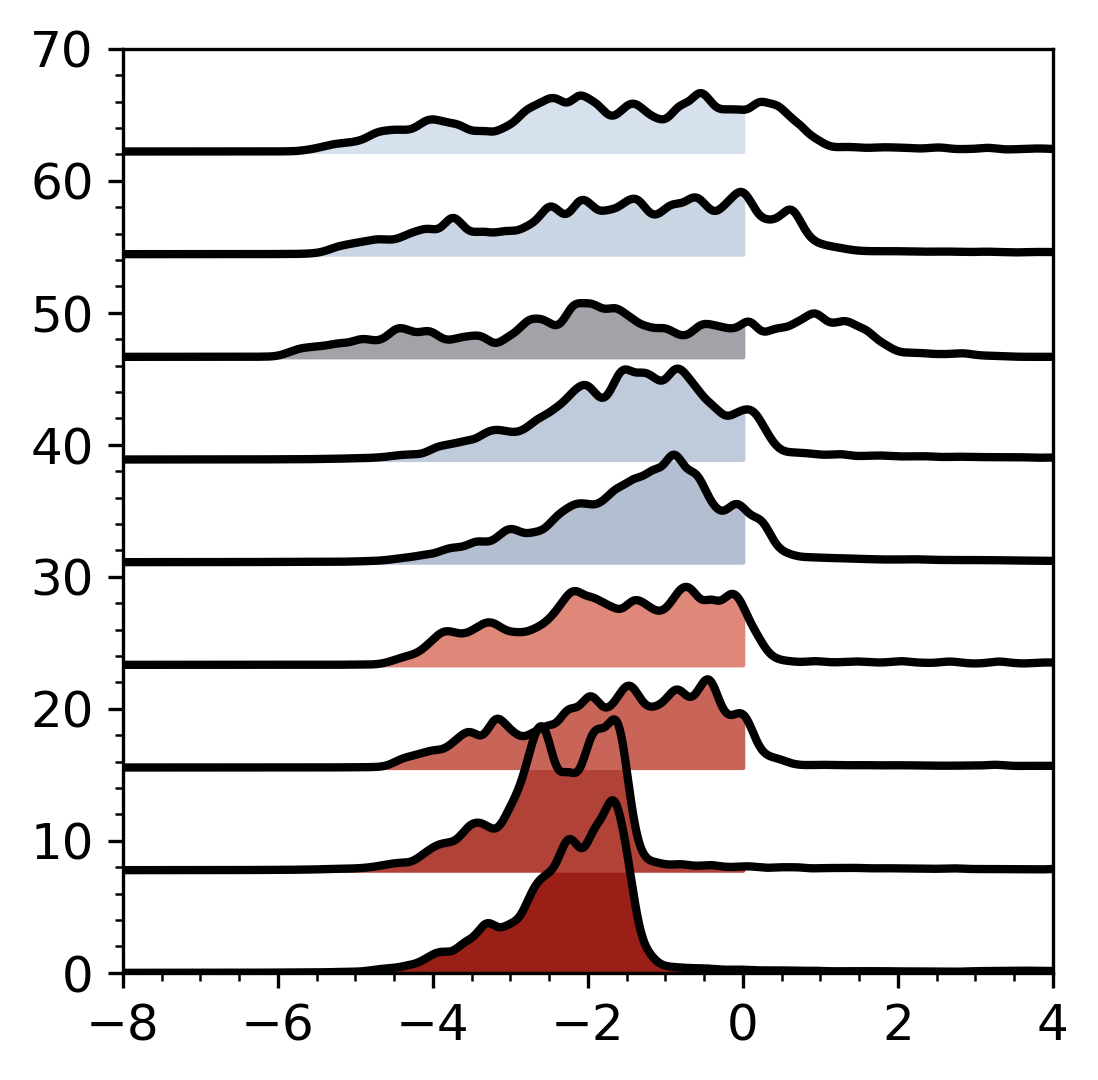

In [46]:
# Directory containing DOS files
directory = "data/pure_dos"  # Replace with the actual directory path

# Colors and offsets for stacking
colors = ["#d7e1ee", "#cbd6e4", "#a4a2a8","#bfcbdb", "#b3bfd1",  "#df8879", "#c86558", "#b04238", "#991f17"]
colors = colors[::-1]

vertical_offsets = np.linspace(0, 70, 10)  # Adjust spacing dynamically

### plot the results
plt.figure(figsize=(4, 4), dpi=300)

# Iterate over all files in the directory
print(sorted(os.listdir(directory)))
for i, filename in enumerate(sorted(os.listdir(directory))):
    file_path = os.path.join(directory, filename)

    try:
        # Use extract_dos to parse the data
        data = extract_dos(file_path)

        x = np.array(data['#Energy'])  # Extract energy values
        y = gaussian_filter1d(np.array(data['d_total']), sigma=100)   # Extract total DOS and apply Gaussian smoothing 
        
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue
    
    # Apply vertical offset
    y_offset = y + vertical_offsets[i]
    
    # Plot the DOS with offset
    plt.plot(x, y_offset, color='black', lw=2, label=filename)
    plt.fill_between(x, vertical_offsets[i], y_offset, where=(x > -7) & (x < 0), color=colors[(i) % len(colors)])

    
    # Calculate and mark the center point
    center, width = calculate_d_band_properties(x, np.array(data['d_total']))

# Format plot
plt.xlim(-8, 4)
plt.ylim(0,70)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# save as .svg
plt.savefig('figures/dos_plots_pm.svg', format='svg', dpi=300, bbox_inches='tight')


## Single atom alloys 

['apd1cu_100.txt', 'apd1cu_111.txt', 'bni1cu_111.txt', 'cni1cu_100.txt', 'crh1cu_100.txt', 'crh1cu_111.txt', 'dru1cu_100.txt', 'dru1cu_111.txt']


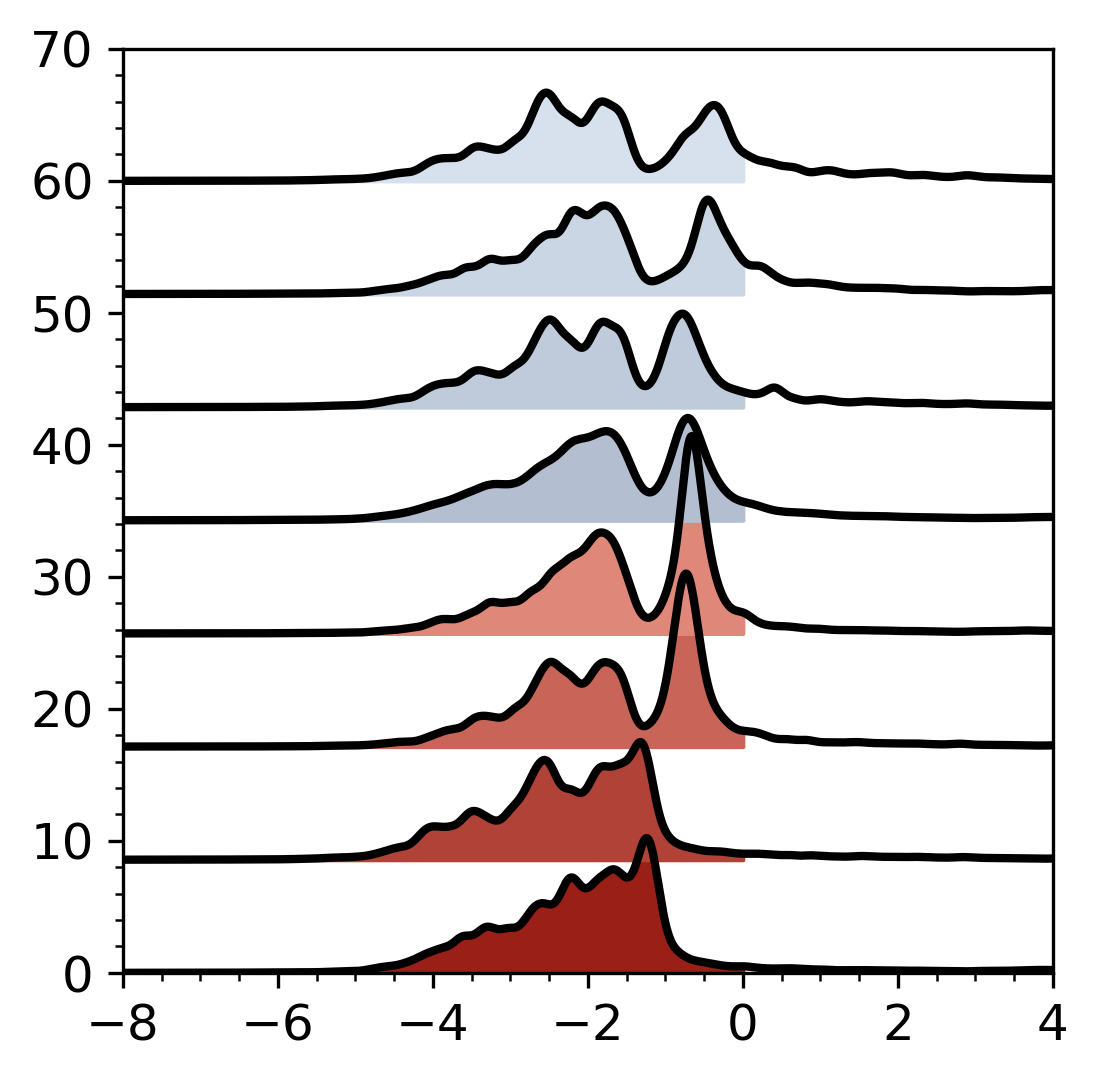

In [47]:
# Directory containing DOS files
directory = "data/saa_dos"  # Replace with the actual directory path

# Colors and offsets for stacking
colors = ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1",  "#df8879", "#c86558", "#b04238", "#991f17"]
colors = colors[::-1]

vertical_offsets = np.linspace(0, 60, len(os.listdir(directory)))  # Adjust spacing dynamically

# Create the plot
plt.figure(figsize=(4, 4), dpi=300)

# Iterate over all files in the directory
print(sorted(os.listdir(directory)))
for i, filename in enumerate(sorted(os.listdir(directory))):
    file_path = os.path.join(directory, filename)
     
    try:
        # Use extract_dos to parse the data
        data = extract_dos(file_path)

        x = np.array(data['#Energy'])  # Extract energy values
        y = gaussian_filter1d(np.array(data['d_total']), sigma=100)   # Extract total DOS
        
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue
    
    # Apply vertical offset
    y_offset = y + vertical_offsets[i]
    
    # Plot the DOS with offset
    plt.plot(x, y_offset, color='black', lw=2, label=filename)
    plt.fill_between(x, vertical_offsets[i], y_offset, where=(x > -7) & (x < 0), color=colors[(i) % len(colors)])

    
    # Calculate and mark the center point
    center, width = calculate_d_band_properties(x, np.array(data['d_total']))


# Format plot
plt.xlim(-8, 4)
plt.ylim(0,70)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# save plot
plt.savefig('figures/dos_plots_saa.svg', format='svg', dpi=300, bbox_inches='tight')


## CHE vs aGC-DFT: Absolute Error 

32.51666561447746
34.44015172061885
31.774105349489023


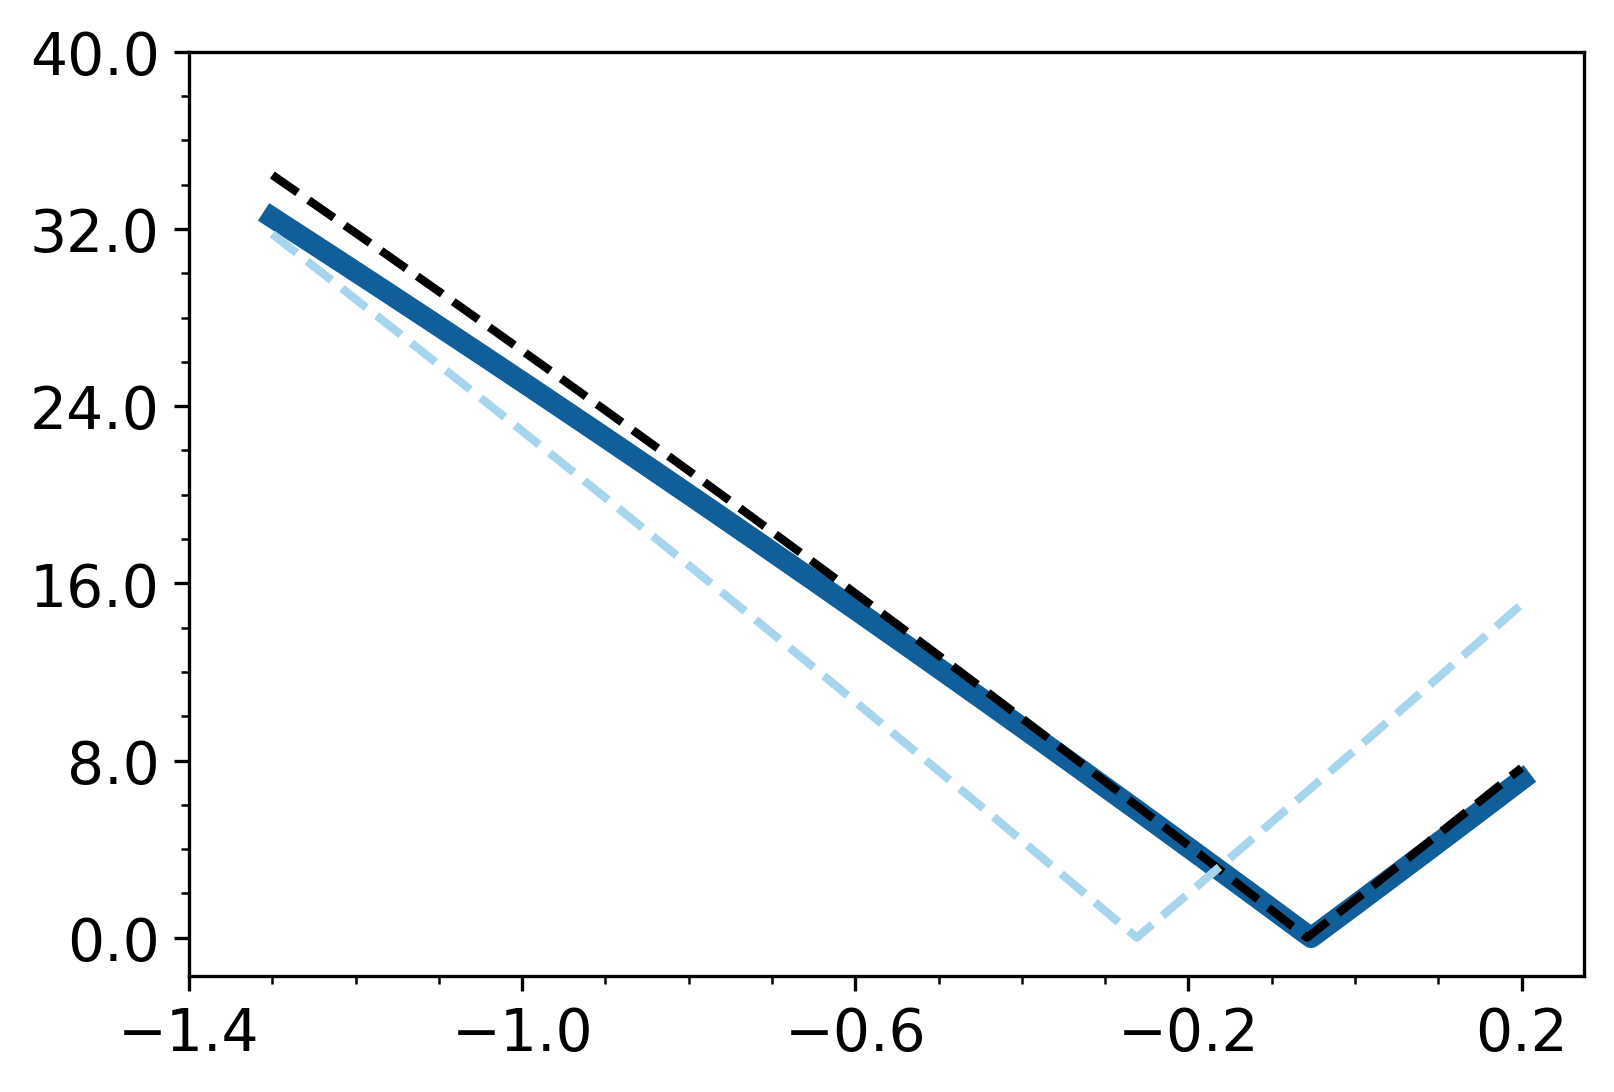

In [48]:
# compute grand free energies from analytical method 
potential = np.linspace(-1.3, 0.2, 100000) # define a new potential range for smooth plot 
U = potential

# calculing no3 adsorption energy with the CHE model
no3_adsorption_che = null(no3_mu, no3_alpha, no3_E, potential) - (null(bare_mu, bare_alpha, bare_E, potential) + hno3 - 1/2*h2) - U 

# compute adsorption energy for d = 3 and epsilion = 78.4 (normal) with aGC-DFT
gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, 3, 78.4)
gc_energy_no3 = aGC_DFT(no3_mu, no3_alpha, no3_E, potential, 3, 78.4)
no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3 - 0.5 * h2) - U 

# compute errors
ni1cu_111_error = np.abs(no3_adsorption.T[:, 1] - no3_adsorption_che.T[:, 1]) * 96.48
cu_111_error = np.abs(no3_adsorption.T[:, 4] - no3_adsorption_che.T[:, 4]) * 96.48
ni1cu_100_error = np.abs(no3_adsorption.T[:, 10] - no3_adsorption_che.T[:, 10]) * 96.48

print(max(ni1cu_111_error))
print(max(cu_111_error))
print(max(ni1cu_100_error))

## plot results ## 
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(potential, ni1cu_111_error, color="#115f9a", linewidth=5) 
plt.plot(potential, cu_111_error, linestyle ="--", color="black", linewidth=2) 
plt.plot(potential, ni1cu_100_error, linestyle ="--", color="#a7d5ed", linewidth=2) 

# formtat plot 
#plt.xticks(np.arange(-1, 1.4, 0.4), fontsize=14)
plt.xticks(np.arange(-1.4, 0.6, 0.4), fontsize=14)
plt.yticks(np.linspace(0.0, 40, 6), fontsize=14)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# save plot
plt.savefig('figures/Eads-no3_error_che_v_aGC.svg', format='svg', bbox_inches='tight')

## Variation in absolute error with double layer permittivity and thickness

/var/folders/sl/r8hdl4bx3j9303t8kxh1v50w0000gn/T/ipykernel_17394/1243491979.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_matrix[i, j] = error  # Store error in matrix


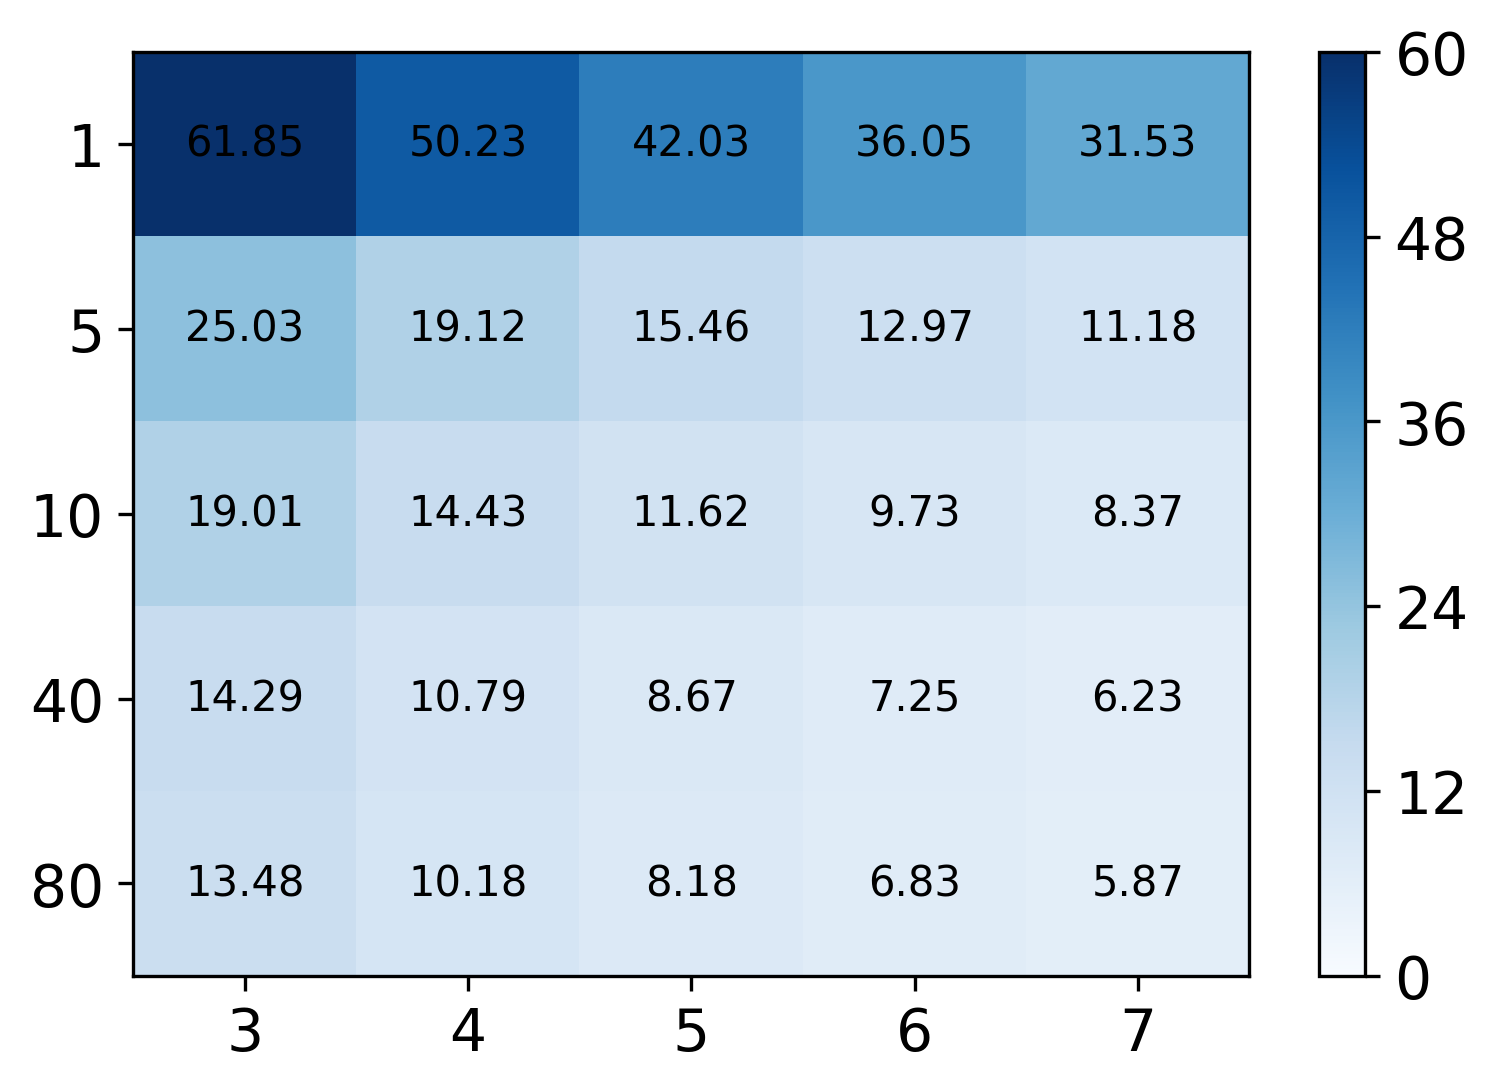

In [49]:
# Define the range of parameters
epsi = np.array([1, 5, 10, 40, 80])
d_thic = np.linspace(3, 7, 5, dtype=int)  # Ensures integer values

potential = np.array([-0.55])  # Single potential value
U = potential

# Initialize error matrix
error_matrix = np.zeros((len(epsi), len(d_thic)))

# Compute adsorption energy using the CHE model
no3_adsorption_che = null(no3_mu, no3_alpha, no3_E, potential) - (null(bare_mu, bare_alpha, bare_E, potential) + hno3 - 0.5 * h2) - U

# Iterate through each combination of epsi and d_thic
for i, e in enumerate(epsi):
    for j, d in enumerate(d_thic):
        gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, d, e)
        gc_energy_no3 = aGC_DFT(no3_mu, no3_alpha, no3_E, potential, d, e)
        no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3 - 0.5 * h2) - U
        # Compute error
        error = np.abs(no3_adsorption.T[:, 1] - no3_adsorption_che.T[:, 1]) * 96.48
        error_matrix[i, j] = error  # Store error in matrix
        
### plot the results ###
plt.figure(figsize=(6, 4), dpi=300)

# Create the heatmap using imshow
cax = plt.imshow(error_matrix, cmap='Blues', interpolation='nearest', aspect='auto', vmin=0, vmax=60)

# Set tick labels and font size for x and y ticks
plt.xticks(ticks=np.arange(len(d_thic)), labels=d_thic, fontsize=14)
plt.yticks(ticks=np.arange(len(epsi)), labels=np.round(epsi, 1), fontsize=14)

# Add numerical labels to each box
for i in range(len(epsi)):
    for j in range(len(d_thic)):
        plt.text(j, i, f"{error_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)

# Add a colorbar with customized ticks
cbar = plt.colorbar(cax, pad=0.05)
cbar.set_ticks(np.linspace(0, 60, num=6))  # Create ticks from 0 to 60
cbar.ax.tick_params(labelsize=14)  # Set font size for color bar tick labels
cbar.ax.yaxis.label.set_fontsize(14)  # Set font size for color bar label

# Save as .svg
plt.savefig('figures/Eads-no3_error_che_v_aGC_heatmap.svg', format='svg', bbox_inches='tight')

# reset the pe potential
potential = np.arange(-1.0, 1.1, 0.1) # V vs SHE
U = potential

## NO3 dissociation barrier over Cu(111): Null, aGC-DFT, eGC-DFT

aGC-DFT symmetry factor: -0.1748590908728897 eV/V and R2 value: 0.9998710502212003
JDFTx esymmetry factor: -0.24214147942359607 eV/V and R2 value: 0.9779553218938275


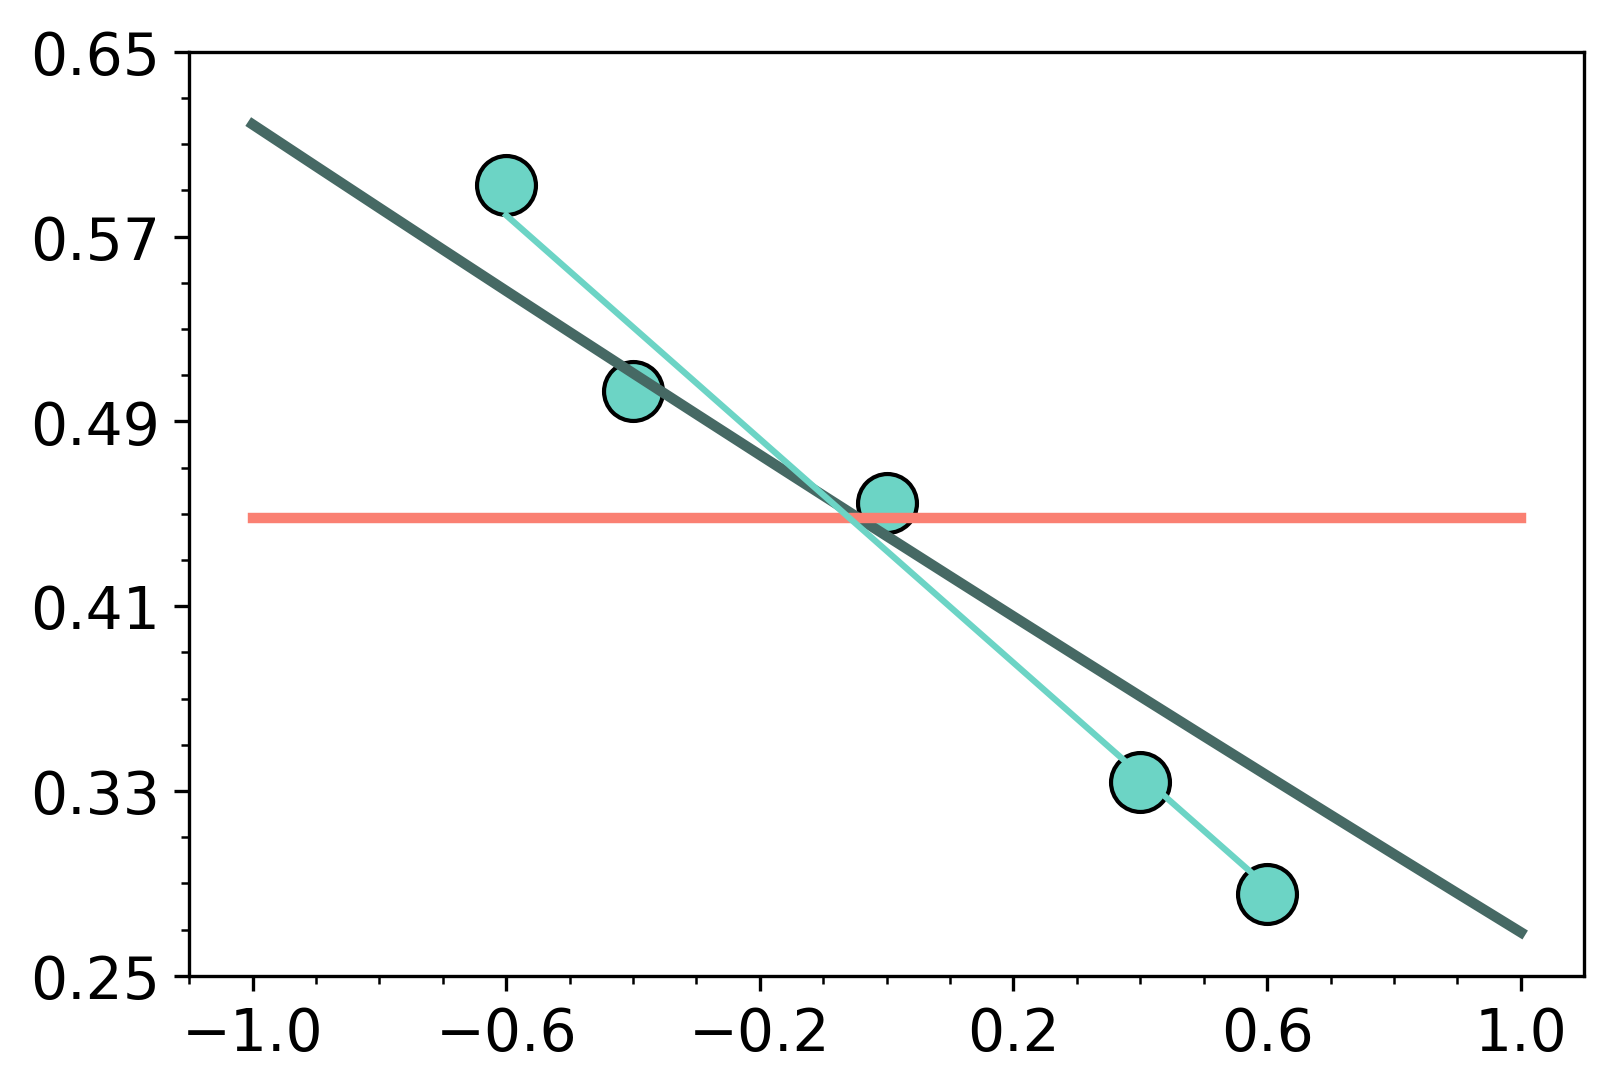

In [50]:
# potential range 
potential = np.arange(-1.0, 1.1, 0.1) # V vs SHE
U = potential

# comptue grand free energies of initial, transition, and final state 
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_G, missing_data), potential, 3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_G, potential, 3, 78.4)

# compute grand free barriers using analytical method 
activation_barrier = gc_energy_trans - gc_energy_no3
activation_barrier_null = null(tstate_mu, tstate_alpha, tstate_G, potential) - null(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_G, missing_data), potential)
activation_barrier_null_cu = activation_barrier_null[4]
activation_barrier_cu = activation_barrier[4]

###### JDFTx
# compute grand free energies using the explicit method using explicir method 
jdftx_potential = np.array([-0.6, -0.4, 0.0, 0.4, 0.6])
j_potential = np.arange(-0.6, 0.7, 0.1)

jdftx_ads_n0 = 707 # electron count for NO3* on Cu(111)
jdftx_ads_phi = (jno3_G - (jno3_surf_charge  - jdftx_ads_n0) * jfermi) 
jdftx_tstate_n0 = 707 # electron count for transitions state on Cu(111)
jdftx_tstate_phi = (jtstate_G  - (jtstate_surf_charge - jdftx_tstate_n0) * jfermi[[2, 3, 5, 7, 8]])  # custom fermi energy range for each potential

jdftx_barrier_phi = (jdftx_tstate_phi - jdftx_ads_phi[[2, 3, 5, 7, 8]]) * 27.2114

# Calculate the lines of best fit for (1) jdftx and aGC-DFT (assuming linear potential depedence)
jdftx_m, jdftx_b, jdftx_r_value, _, _ = linregress(jdftx_potential, jdftx_barrier_phi) # compute symmetry factor
aGC_eval, aGC_intercept, aGC_r_value, _, _ = linregress(potential, activation_barrier[4]) # compute symmetry factor
print(f'aGC-DFT symmetry factor: {aGC_eval} eV/V and R2 value: {aGCr_value**2}')
print(f'JDFTx esymmetry factor: {jdftx_m} eV/V and R2 value: {jdftx_r_value**2}')


### plot the results
plt.figure(figsize=(6, 4), dpi=300)

plt.plot(potential, activation_barrier_cu, color="#466964", linewidth=2.5) # aGC-DFT 
plt.plot(potential, activation_barrier_null_cu, color='salmon', linewidth=2.5) # Null
plt.scatter(jdftx_potential, jdftx_barrier_phi, color="#6cd4c5", s=200, edgecolor='black') # JDFTx scatter 
plt.plot(j_potential, jdftx_m * j_potential + jdftx_b,  color="#6cd4c5", linestyle='-') # JDFTx line of best fit


# plot formatting
plt.xticks(np.arange(-1.0, 1.4, 0.4), fontsize=14)
plt.yticks(np.linspace(0.25, 0.65, 6), fontsize=14)
plt.ylim(None, 0.65)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

#  save as .svg 
plt.savefig('figures/Ebarrier_null_aGC_eGC.svg', format='svg', dpi=300, bbox_inches='tight')

## Symmetry factor vs the change in the surface normal dipole moment

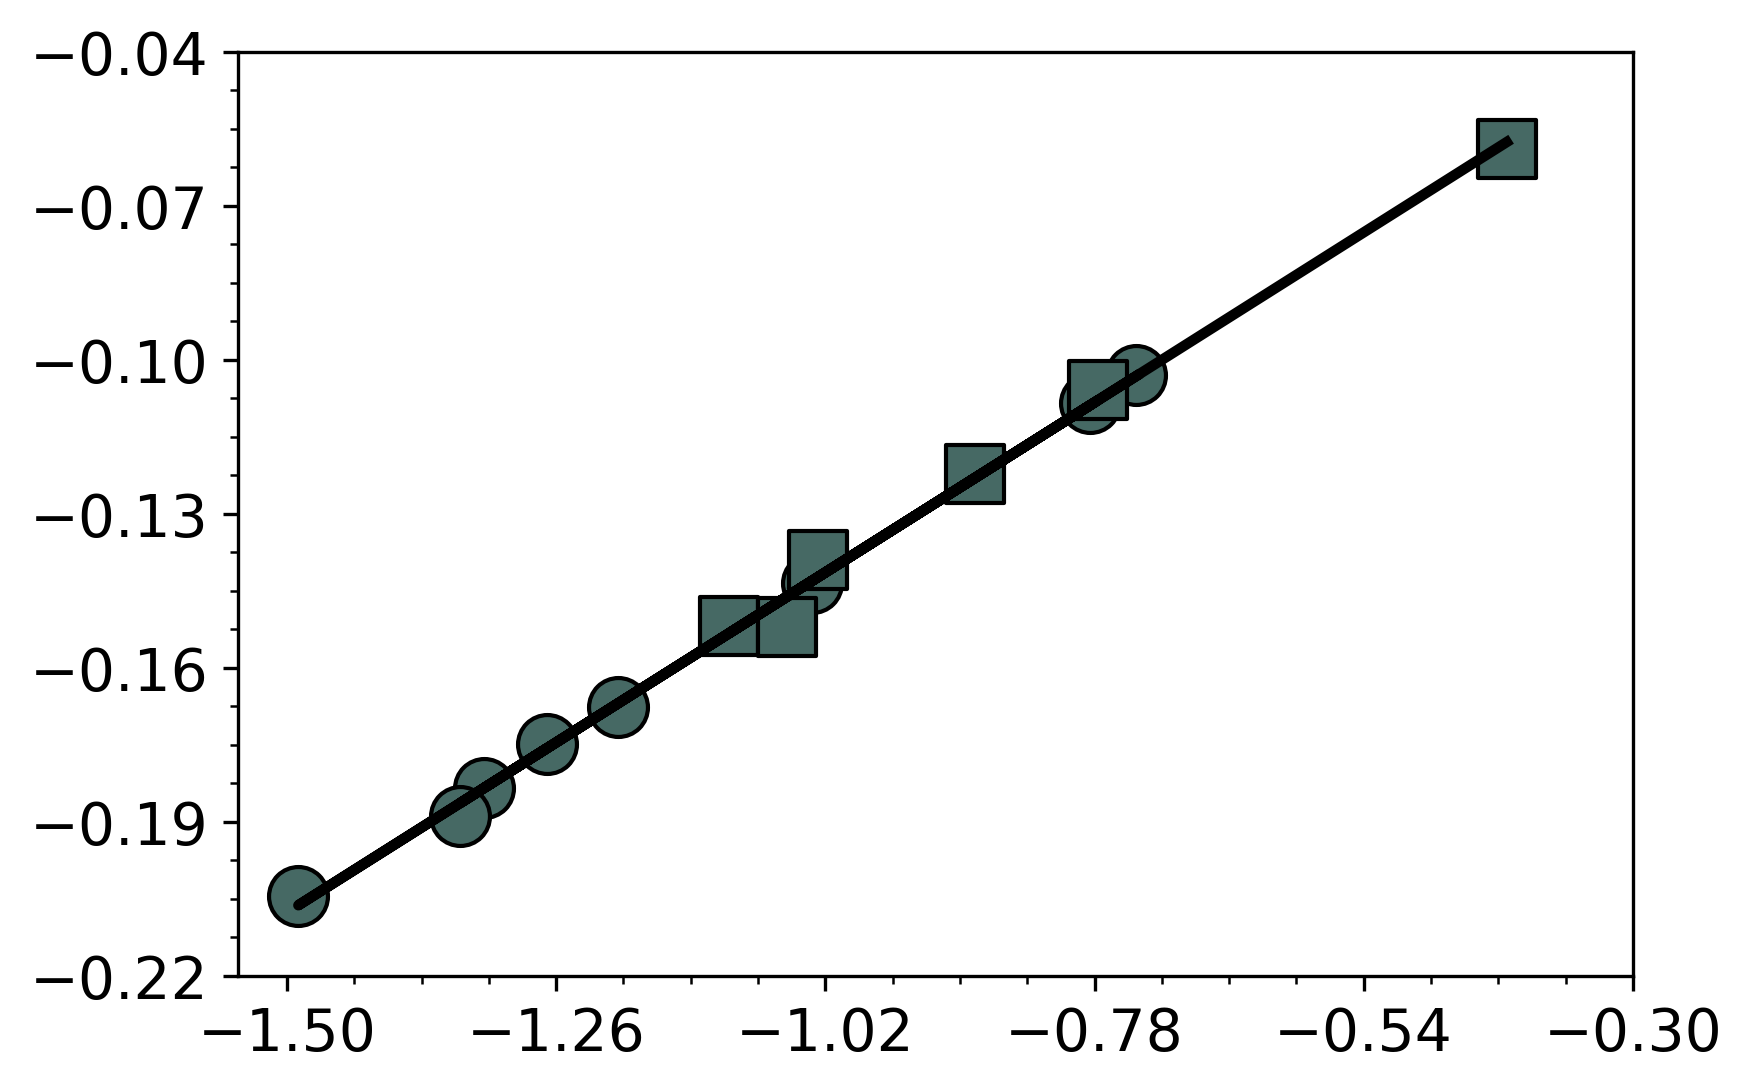

In [51]:
# compute grand gree energies using aGC-DFT
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential,  3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential,  3, 78.4)

# compute symmetry factor for each 
no3_barrier = gc_energy_trans - gc_energy_no3 
symmetry_factor = []
r2_value = []

for metal in no3_barrier: 
    slope, intercept, r_value, p_value, std_err = linregress(U, metal)
    symmetry_factor.append(slope)
    r2_value.append(r_value**2)
symmetry_factor = np.array(symmetry_factor) 

# fit change in dipole moment versus the symmetry factor
tstate_dipole_shift = (tstate_mu - np.delete(no3_mu, missing_data)) * 4.803
m, b, r_value, p_value, std_err = linregress(tstate_dipole_shift, symmetry_factor)

## plot results ##
plt.figure(figsize=(6,4), dpi=300)
sc = plt.scatter(
    tstate_dipole_shift[:8], symmetry_factor[:8],
    c="#466964",
    s=200,               # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

sc = plt.scatter(
    tstate_dipole_shift[8:14], symmetry_factor[8:14],
    c="#466964",  # Color based on electrosorption values
    marker='s',          # Square marker
    s=200,               # Marker size
    edgecolors='black',
    alpha=1          # Transparency
)

# plot line of best fit 
plt.plot(tstate_dipole_shift, m * tstate_dipole_shift + b, color='black', linewidth=2.5)

# plot formatting
plt.yticks(np.linspace(-0.22, -0.04, 7), fontsize=14)
plt.xticks(np.linspace(-1.5, -0.3, 6), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Show plot
plt.savefig('figures/dipole_moment_v_barrier_symmetry factor.svg', format='svg', dpi=300, bbox_inches='tight')

## Change in surface normal dipole momenet vs charge transfer for transition state

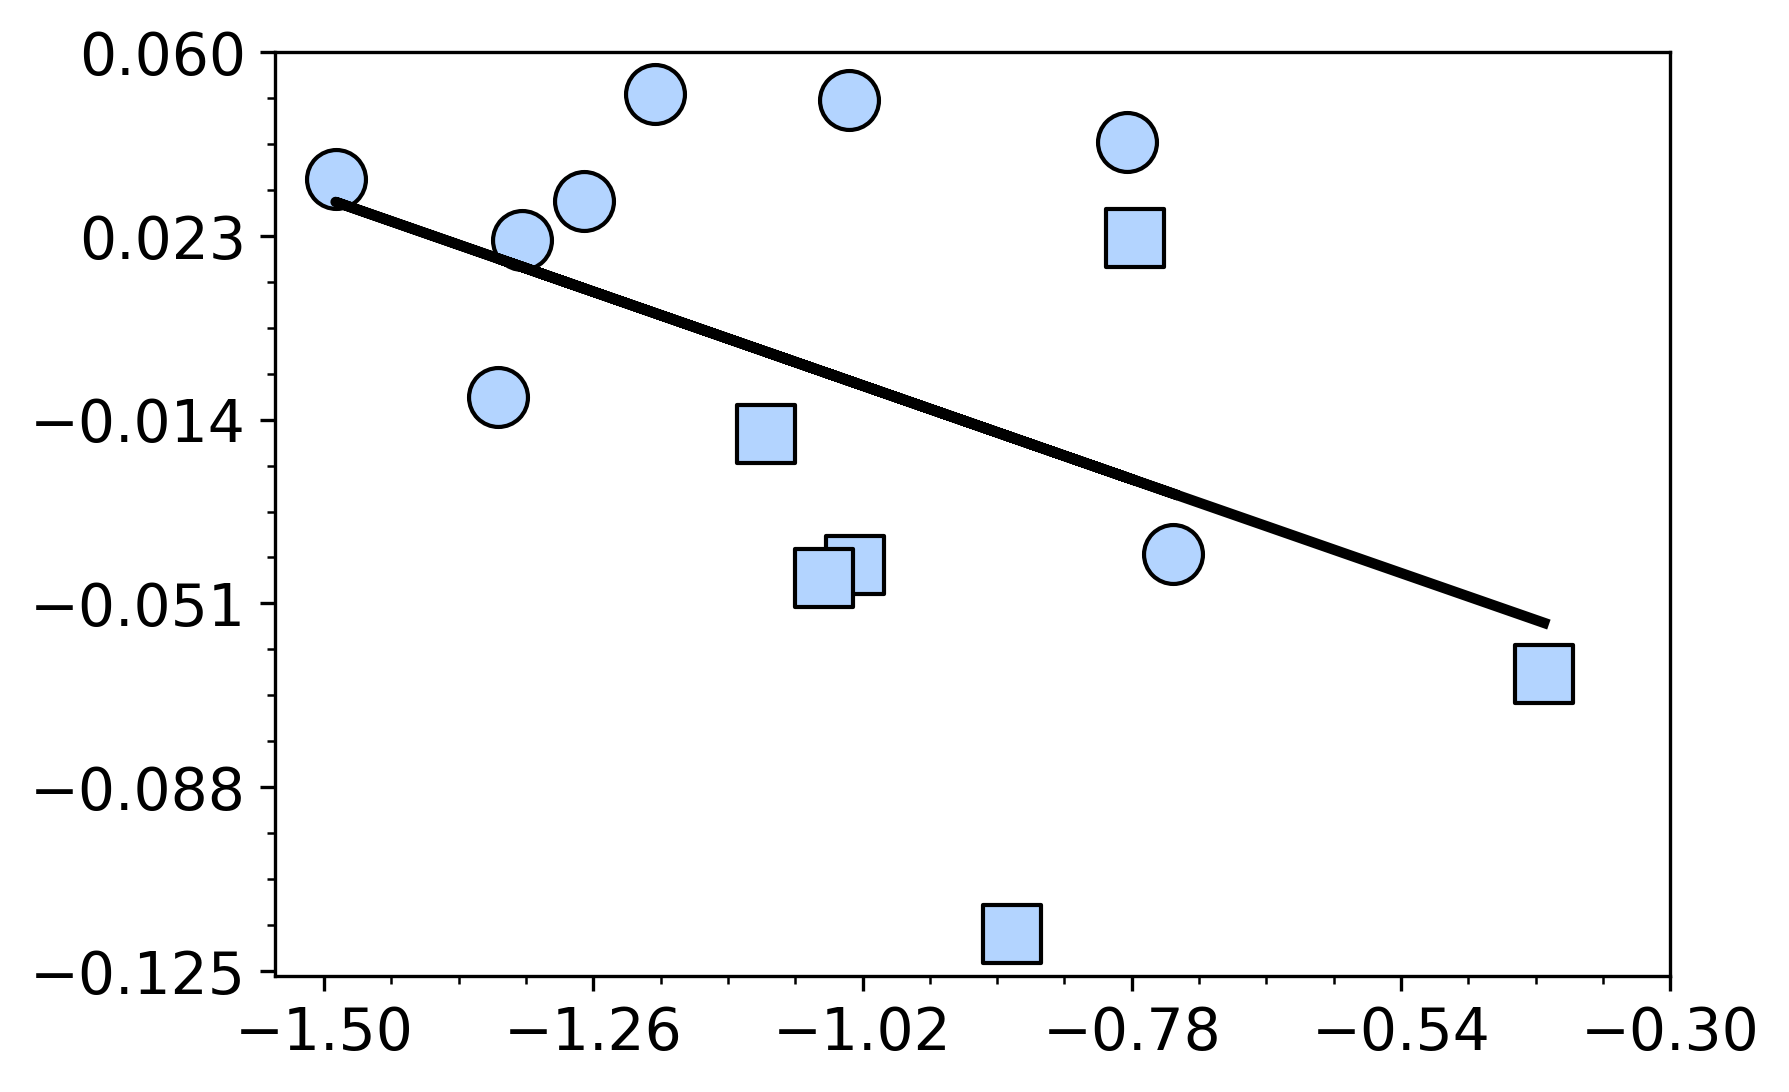

In [52]:
# compute chanrge transfer from adsobred state to transiton state
delta_q = tstate_q - np.delete(no3_q, missing_data)
tstate_dipole_shift = (tstate_mu - np.delete(no3_mu, missing_data)) * 4.803

# regress charge transfer versus the change in surface normal dipole moment 
m, b, r_value, p_value, std_err = linregress(tstate_dipole_shift, delta_q)

## plot results ##
plt.figure(figsize=(6,4), dpi=300)
sc = plt.scatter(
    tstate_dipole_shift[:8], delta_q[:8],
    c="#b3d4ff",
    s=200,               # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

sc = plt.scatter(
    tstate_dipole_shift[8:14], delta_q[8:14],
    c="#b3d4ff",
    s=200,  
    marker='s',           # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

# plot line of best fit
plt.plot(tstate_dipole_shift, m * tstate_dipole_shift + b, color='black', linewidth=2.5)

# plot formatting
plt.yticks(np.linspace(-0.125, 0.06, 6), fontsize=14)
plt.xticks(np.linspace(-1.5, -0.3, 6), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# save as .svg
plt.savefig('figures/barrier_dipole_moment_v_charge_transfer.svg', format='svg', dpi=300, bbox_inches='tight')

# aGC-DFT vs Null: Absolute error for NO3* dissociation barrier

21.72965637837353
21.73843238540176
15.059073107621202


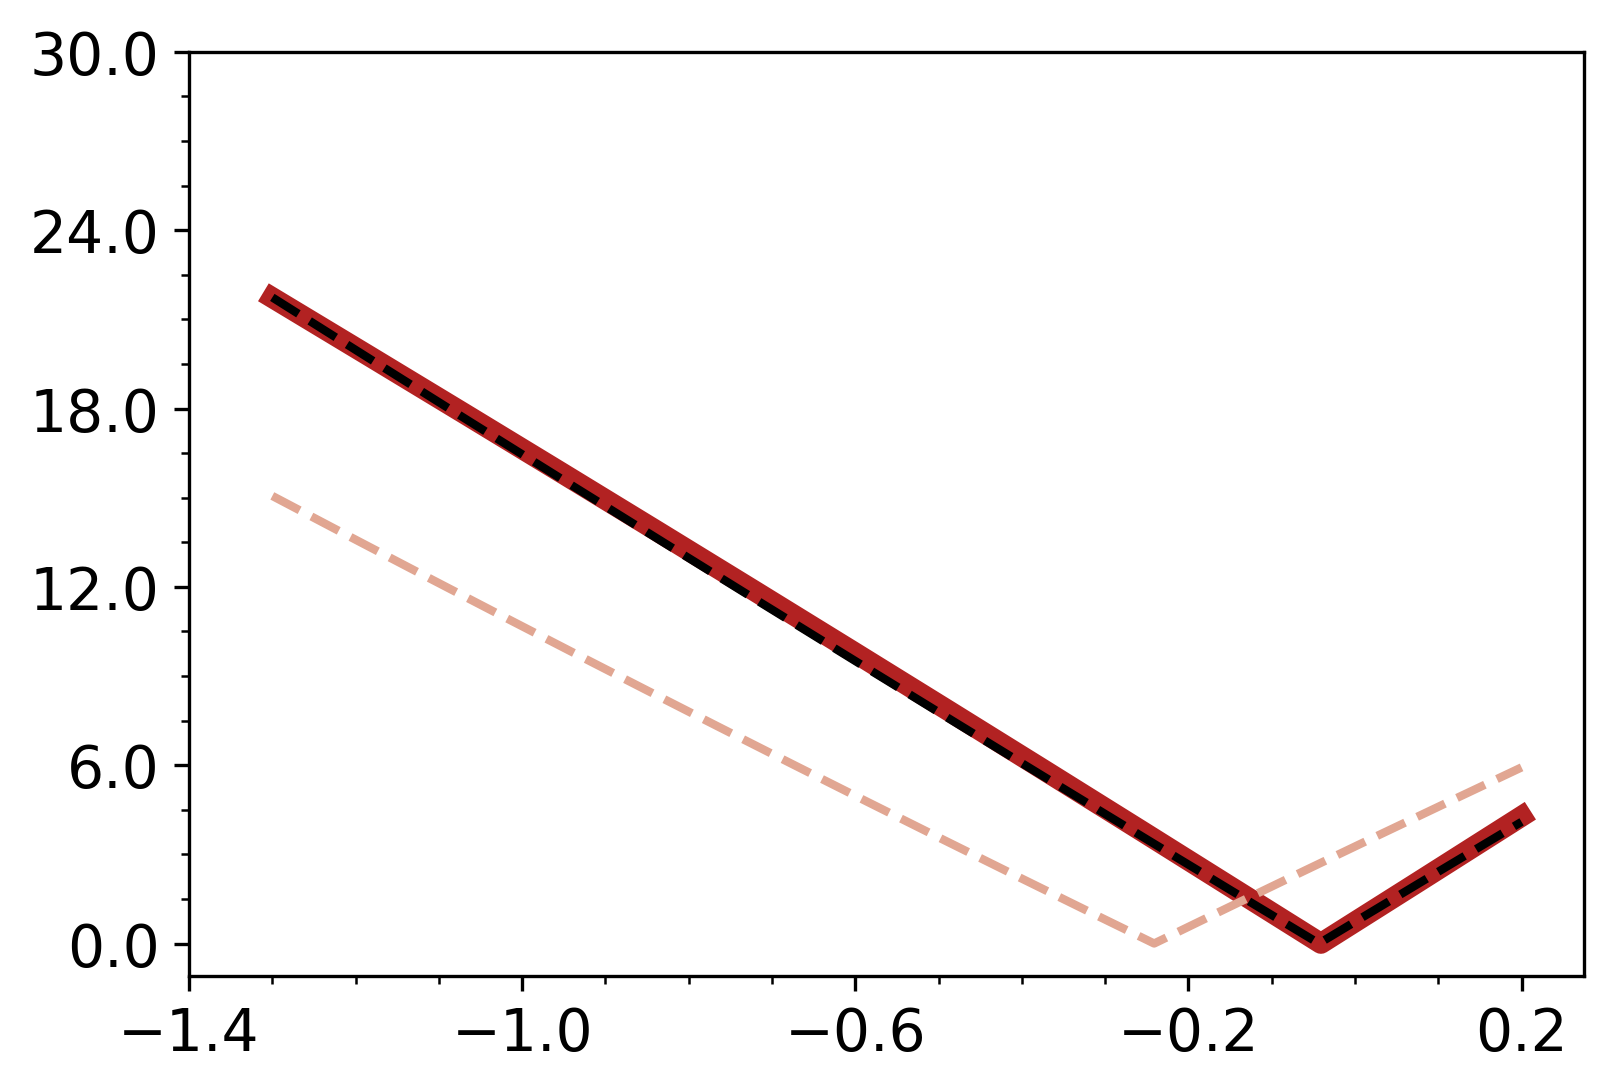

In [53]:
# reset potential for smooth distribution
potential = np.linspace(-1.3, 0.2, 100000)
U = potential

# compute grand free barriers and rwction energy 
activation_barrier_null = null(tstate_mu, tstate_alpha, tstate_E, potential) - null(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential)

# compute adsorption energy for d = 3 and epsilion = 78.4 (normal)
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential, 3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential, 3,  78.4)
activation_barrier = gc_energy_trans - gc_energy_no3

# compute the error 
ni1cu_111_error = np.abs(activation_barrier.T[:, 1] - activation_barrier_null.T[:, 1]) * 96.48
cu_111_error = np.abs(activation_barrier.T[:, 4] - activation_barrier_null.T[:, 4]) * 96.48
ni1cu_100_error = np.abs(activation_barrier.T[:, 9] - activation_barrier_null.T[:, 9]) * 96.48

print(max(ni1cu_111_error))
print(max(cu_111_error))
print(max(ni1cu_100_error))

## plot results ## 
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(potential, ni1cu_111_error, color="firebrick", linewidth=5) 
plt.plot(potential, cu_111_error, linestyle="--",  color="black", linewidth=2) 
plt.plot(potential, ni1cu_100_error, linestyle="--",  color="#e1a692", linewidth=2) 

# plot formatting
plt.xticks(np.arange(-1.4, 0.6, 0.4), fontsize=14)
plt.yticks(np.linspace(0.0, 30, 6), fontsize=14)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# save as .svg
plt.savefig('figures/barrier_error_null_v_aGC.svg', format='svg', dpi=300, bbox_inches='tight')

# Variation in absolute error with double layer permittivity and thickness

/var/folders/sl/r8hdl4bx3j9303t8kxh1v50w0000gn/T/ipykernel_17394/3053448063.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_matrix[i, j] = error  # Store error in matrix


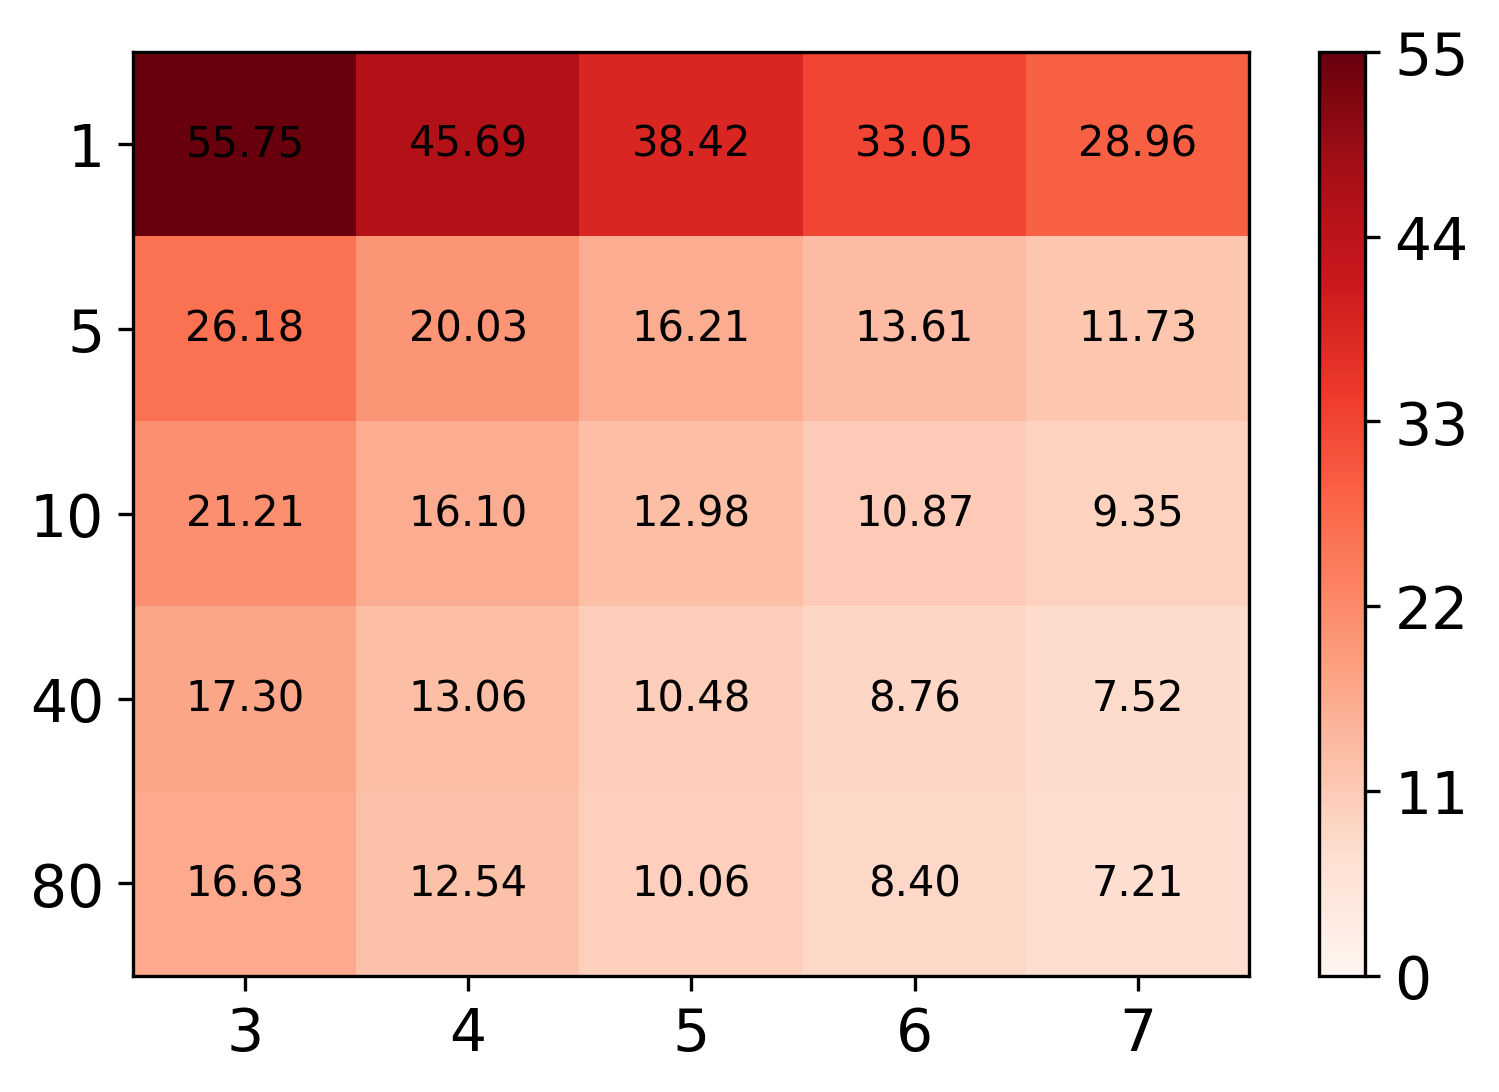

In [54]:
# Define the range of parameters
epsi = np.array([1, 5, 10, 40, 80])
d_thic = np.linspace(3, 7, 5, dtype=int)  # Ensures integer values

potential = np.array([-1.00])  # Single potential value
U = potential

# Initialize error matrix
error_matrix = np.zeros((len(epsi), len(d_thic)))

# Compute adsorption energy using the CHE model
activation_barrier_null = null(tstate_mu, tstate_alpha, tstate_E, potential) - null(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential)

# Iterate through each combination of epsi and d_thic
for i, e in enumerate(epsi):
    for j, d in enumerate(d_thic):
        gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential, d, e)
        gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential, d, e)
        activation_barrier = gc_energy_trans - gc_energy_no3
        error = np.abs(activation_barrier.T[:, 1] - activation_barrier_null.T[:,1]) * 96.48
        error_matrix[i, j] = error  # Store error in matrix

# Plot heatmap using Matplotlib only
plt.figure(figsize=(6, 4), dpi=300)

# Create the heatmap using imshow
cax = plt.imshow(error_matrix, cmap='Reds', interpolation='nearest', aspect='auto', vmin=0, vmax=55)

# Customize ticks and labels
plt.xticks(ticks=np.arange(len(d_thic)), labels=d_thic, fontsize=14)
plt.yticks(ticks=np.arange(len(epsi)), labels=np.round(epsi, 1), fontsize=14)

# Add numerical labels to each box
for i in range(len(epsi)):
    for j in range(len(d_thic)):
        plt.text(j, i, f"{error_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)

# speciify coloe bar 
cbar = plt.colorbar(cax, pad=0.05)
cbar.set_ticks(np.linspace(0, 55, num=6))  # Set ticks from 0 to 50
cbar.ax.tick_params(labelsize=14)  # Set font size for color bar tick labels
cbar.ax.yaxis.label.set_fontsize(14)  # Set font size for color bar label

# save as .svg
plt.savefig('figures/barrier_error_null_v_aGC_heatmap.svg', format='svg', dpi=300, bbox_inches='tight')

# reset the pe potential
potential = np.arange(-1.0, 1.1, 0.1) # V vs SHE
U = potential


# aGC-DFT analysis of Nitrate Dissociation Reaction Energy 

In [55]:
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential,  3, 78.4)
gc_energy_final = aGC_DFT(fstate_mu, fstate_alpha, fstate_E, potential,  3, 78.4)

# compute symmetry factor for each 
no3_rxn_energy = gc_energy_final - gc_energy_no3 
symmetry_factor = []
r2_value = []

for metal in no3_rxn_energy: 
    slope, intercept, r_value, p_value, std_err = linregress(U, metal)
    symmetry_factor.append(slope)
    r2_value.append(r_value**2)
symmetry_factor = np.array(symmetry_factor) 